# %% [markdown]
# # Q2: Image Blurring - Implementation and Performance Analysis
# 
# This notebook implements and compares two approaches for applying a 3x3 mean blur filter:
# 1. Iterative Python implementation using nested loops
# 2. Vectorized NumPy implementation

# %% [markdown]
# ## 1. Setup and Dependencies

# %%

In [7]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import time

# %% [markdown]
# ## 2. Image Generation
# 
# Generate a 400x200 grayscale image with "SSD TAs ARE THE BEST" centered in white text

# %%

In [8]:
def generate_image():
    """
    Generate a 400x200 grayscale image with centered text.
    
    Returns:
        numpy.ndarray: Generated image as a NumPy array
    """
    # Create a black background image (400x200, grayscale)
    img = Image.new('L', (400, 200), color=0)
    draw = ImageDraw.Draw(img)
    
    # Text to display
    text = "SSD TAs ARE THE BEST"
    
    # Try to use a large font, fallback to default if not available
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 24)
    except:
        try:
            font = ImageFont.truetype("arial.ttf", 24)
        except:
            # Use default font if no truetype fonts available
            font = ImageFont.load_default()
    
    # Get text bounding box to center it
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    # Calculate position to center the text
    x = (400 - text_width) // 2
    y = (200 - text_height) // 2
    
    # Draw white text on black background
    draw.text((x, y), text, fill=255, font=font)
    
    # Convert to NumPy array
    return np.array(img)

# Generate the original image
original_image = generate_image()
print(f"Generated image shape: {original_image.shape}")
print(f"Image dtype: {original_image.dtype}")

Generated image shape: (200, 400)
Image dtype: uint8


# %% [markdown]
# ## 3. Implementation - Task 1: Iterative Python Blur

# %%

In [9]:
def blur_python(image):
    """
    Apply 3x3 mean blur using nested for loops (iterative approach).
    Excludes outermost single-pixel boundary.
    
    Args:
        image (numpy.ndarray): Input grayscale image
    
    Returns:
        numpy.ndarray: Blurred image
    """
    height, width = image.shape
    blurred = np.zeros_like(image)
    
    # Copy border pixels as-is
    blurred[0, :] = image[0, :]
    blurred[-1, :] = image[-1, :]
    blurred[:, 0] = image[:, 0]
    blurred[:, -1] = image[:, -1]
    
    # Iterate through interior pixels (excluding border)
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            # Calculate mean of 3x3 neighborhood
            neighborhood_sum = 0
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    neighborhood_sum += image[i + di, j + dj]
            
            blurred[i, j] = neighborhood_sum // 9
    
    return blurred

# %% [markdown]
# ## 4. Implementation - Task 2: Vectorized NumPy Blur

# %%

In [10]:
def blur_numpy(image):
    """
    Apply 3x3 mean blur using vectorized NumPy operations.
    No explicit Python loops.
    
    Args:
        image (numpy.ndarray): Input grayscale image
    
    Returns:
        numpy.ndarray: Blurred image
    """
    height, width = image.shape
    blurred = np.zeros_like(image)
    
    # Copy border pixels
    blurred[0, :] = image[0, :]
    blurred[-1, :] = image[-1, :]
    blurred[:, 0] = image[:, 0]
    blurred[:, -1] = image[:, -1]
    
    # Vectorized computation for interior pixels
    # Extract all 9 shifted versions of the image
    top_left = image[0:height-2, 0:width-2]
    top_center = image[0:height-2, 1:width-1]
    top_right = image[0:height-2, 2:width]
    
    mid_left = image[1:height-1, 0:width-2]
    mid_center = image[1:height-1, 1:width-1]
    mid_right = image[1:height-1, 2:width]
    
    bottom_left = image[2:height, 0:width-2]
    bottom_center = image[2:height, 1:width-1]
    bottom_right = image[2:height, 2:width]
    
    # Sum all 9 regions and divide by 9 (mean)
    blurred[1:height-1, 1:width-1] = (
        top_left + top_center + top_right +
        mid_left + mid_center + mid_right +
        bottom_left + bottom_center + bottom_right
    ) // 9
    
    return blurred

# %% [markdown]
# ## 5. Benchmarking

# %%
# Benchmark blur_python

In [11]:
# Benchmark blur_python
start_time = time.time()
blurred_python = blur_python(original_image)
python_time = time.time() - start_time

print(f"blur_python execution time: {python_time:.6f} seconds")

# Benchmark blur_numpy
start_time = time.time()
blurred_numpy = blur_numpy(original_image)
numpy_time = time.time() - start_time

print(f"blur_numpy execution time: {numpy_time:.6f} seconds")
print(f"\nSpeedup factor: {python_time / numpy_time:.2f}x")


blur_python execution time: 0.374155 seconds
blur_numpy execution time: 0.000485 seconds

Speedup factor: 771.54x


# %% [markdown]
# ## 6. Visualization

# %%
# Create figure with three subplots

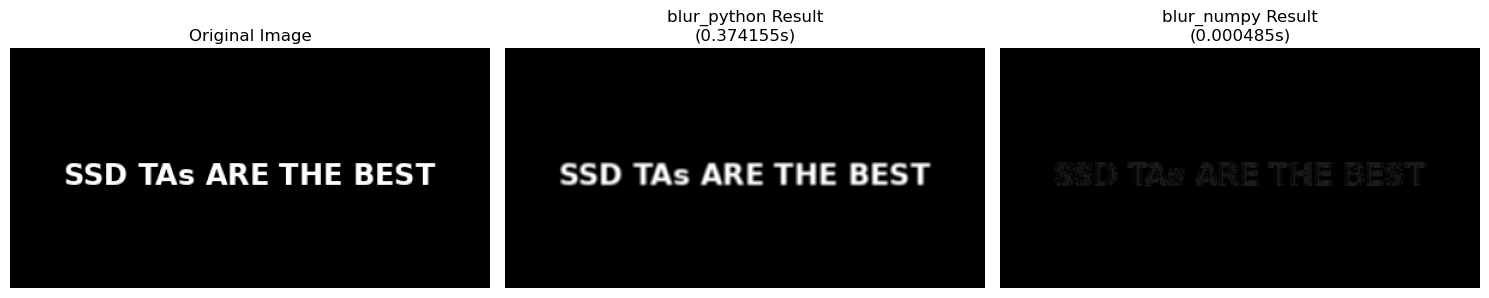


Are both implementations identical? False
Maximum difference: 228


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(original_image, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Python blurred image
axes[1].imshow(blurred_python, cmap='gray', vmin=0, vmax=255)
axes[1].set_title(f'blur_python Result\n({python_time:.6f}s)')
axes[1].axis('off')

# NumPy blurred image
axes[2].imshow(blurred_numpy, cmap='gray', vmin=0, vmax=255)
axes[2].set_title(f'blur_numpy Result\n({numpy_time:.6f}s)')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('blur_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Verify both implementations produce the same result
print(f"\nAre both implementations identical? {np.array_equal(blurred_python, blurred_numpy)}")
if not np.array_equal(blurred_python, blurred_numpy):
    print(f"Maximum difference: {np.max(np.abs(blurred_python.astype(int) - blurred_numpy.astype(int)))}")